In [8]:
%cd ..
%rm -rf Beta-Dirichlet-VAE-for-BHU

/content/Beta-Dirichlet-VAE-for-BHU


#Clone and install the dependencies

In [1]:


!git clone https://github.com/anonymous1828/Beta-Dirichlet-VAE-for-BHU.git
%cd Beta-Dirichlet-VAE-for-BHU
!pip install -r requirements.txt



Cloning into 'Beta-Dirichlet-VAE-for-BHU'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 117 (delta 5), reused 14 (delta 4), pack-reused 93 (from 2)
Receiving objects: 100% (117/117), 47.07 MiB | 10.70 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (31/31), done.
/content/Beta-Dirichlet-VAE-for-BHU
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 937.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━

# import the necessary libraries

In [1]:
%cd Beta-Dirichlet-VAE-for-BHU
import os
from scipy.io import loadmat

import torch
import torch.nn as nn
from   torch.utils.data import DataLoader


import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from utils.data.synth_data import get_synth_dataset
from utils.data.hsi_dataset_class import HSIDataset
from utils.data.real_data         import get_dataset

from model.dir_vae import DirVAE

from utils.optimization.constraint  import NonNegConstraint
from utils.optimization.optim_utils import get_optimizer

from utils.loss.losses_utils import (
    get_reconstruction_loss_fn,
    get_regularization_loss_fn
)

from trainer import UnsupervisedTrainer
from utils.metrics import get_average_accuracy_on_M, get_accuracy_on_M

from utils.logs_fn import create_log_folder, log_metrics, log_figure


/content/Beta-Dirichlet-VAE-for-BHU


# Define the Losses

## GammaKL

In [2]:
import numpy as np
class GammaKL:
    def __init__(self, alphas: torch.Tensor, reduction: str = "mean", mode: str = "default", eps: float = 1e-6):
        if mode not in ["default", "cnn"]:
            raise ValueError("mode must be 'default' or 'cnn'")
        self.alphas = alphas.to(dtype=torch.float32)
        self.reduction = reduction
        self.mode = mode
        self.eps = eps

    def to(self, device):
        self.alphas = self.alphas.to(device)
        return self

    def __call__(self, input: torch.Tensor):
        input = torch.clamp(input, min=self.eps, max=30.0)
        if self.mode == "default":
            batch_size = input.shape[0]
            alphas_prior = self.alphas.expand(batch_size, -1)
            sum_dim = -1
        else:
            batch_size, n_ems, H, W = input.shape
            alphas_prior = self.alphas.view(1, n_ems, 1, 1).expand(batch_size, n_ems, H, W)
            sum_dim = 1
        kl = (input - alphas_prior) * torch.digamma(input + self.eps) - \
             torch.lgamma(input + self.eps) + torch.lgamma(alphas_prior + self.eps)
        loss = torch.sum(kl, dim=sum_dim)
        if self.mode == "cnn" and self.reduction in ["sum", "mean"]:
            loss = torch.sum(loss, dim=[1, 2])  # Shape: (batch_size,)
            if self.reduction == "mean":
                loss = loss / (n_ems * H * W)  # Average over all elements
        if self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "mean":
            return loss.mean() if self.mode == "default" else loss.mean()  # Already averaged for cnn
        elif self.reduction == "none":
            return loss
        else:
            raise ValueError("Reduction must be 'sum', 'mean', or 'none'")

## SADLoss

In [3]:

class SADLoss:
    """
        Spectral Angle Distance (SAD) loss function.

        Parameters
        ----------
        eps : avoid division by zero
        reduction : reduction method for the loss.
                    Options are "sum", "mean" or "none"
                            (the latter returns a tensor of size (..., n_samples)).
        mode : "default" for simple spectral vector as sample,"cnn" for patch images
        Returns
        -------
        out: shape (n_batch,
             spectral angle distance
    """
    def __init__(self,
                 reduction: str = "mean",
                 eps: float = 1e-8,mode:str ='default') -> None:

        self.reduction = reduction
        self.eps       = torch.tensor(eps)
        self.mode = mode

    def __repr__(self):
        return f"{self.__class__.__name__}(reduction='{self.reduction}', eps={self.eps})"

    def to(self, device):
        self.eps.to(device)
        return self

    def __call__(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:

        if len(target.shape) < 2: target = target.unsqueeze(0)
        if len(input.shape)  < 2: input  = input.unsqueeze(0)
        if self.mode == 'default':  # For 1D spectral vectors (B, C)
            target_norm = torch.norm(target, p=2, dim=1)
            input_norm  = torch.norm(input,  p=2, dim=1)
        else:  # For hyperspectral patches (B, C, H, W)
            target_norm = torch.norm(target, p=2, dim=1, keepdim=True)
            input_norm  = torch.norm(input,  p=2, dim=1, keepdim=True)

        norm_factor = target_norm * input_norm

        scalar_product = torch.sum(target * input, dim=1)

        # eps at denominator + 1e-6 in cos for numerical stability
        cos = scalar_product / torch.max(norm_factor, self.eps)
        cos = torch.clamp(cos, -1 + 1e-6, 1 - 1e-6)

        if   self.reduction == "sum":  loss = torch.acos(cos).sum()
        elif self.reduction == "mean": loss = torch.acos(cos).mean()
        elif self.reduction == "none": loss = torch.acos(cos)
        else:
            raise ValueError("Invalid reduction type. Must be either'sum', 'none' or 'mean'.")

        return loss
input=torch.FloatTensor(np.ones((1,10,2,2)))
target=torch.FloatTensor(np.ones((1,10,2,2)))
sad=SADLoss(mode='cnn')
print(sad(input,target))


tensor(0.0014)


#jasper_ridge Dataset
## install the end4.mat from **https://huggingface.co/datasets/danaroth/jasper_ridge/tree/main** and add it into Datasets folder

In [4]:
from scipy.io import loadmat
import numpy as np

# Load the .mat file
data = loadmat("/content/Beta-Dirichlet-VAE-for-BHU/Datasets/end4.mat")

# Show keys in the file
print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'cood', 'M', 'A'])


In [5]:
M = data['M']  # shape: (bands, n_endmembers)
A = data['A'] # shape: (n_endmembers, pixels)
n_ems=M.shape[1]
print("Shape of M:", M.shape)
print("Shape of A:",A.shape)

Shape of M: (198, 4)
Shape of A: (4, 10000)


## display the endmembers

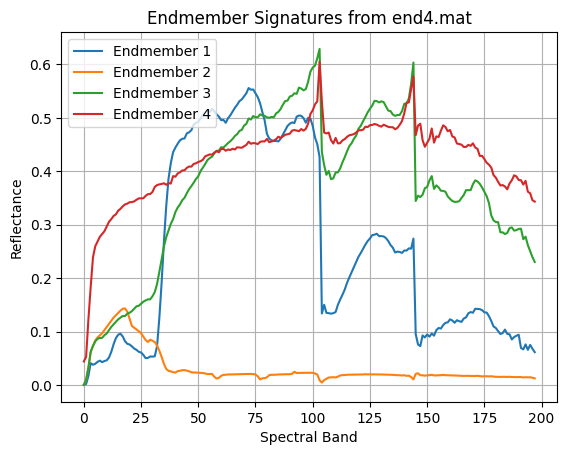

In [6]:
import matplotlib.pyplot as plt

for i in range(M.shape[1]):
    plt.plot(M[:, i], label=f"Endmember {i+1}")

plt.xlabel("Spectral Band")
plt.ylabel("Reflectance")
plt.title("Endmember Signatures from end4.mat")
plt.legend()
plt.grid(True)
plt.show()


##generate the Y=M.A

Shape of Y:  (10000, 198)


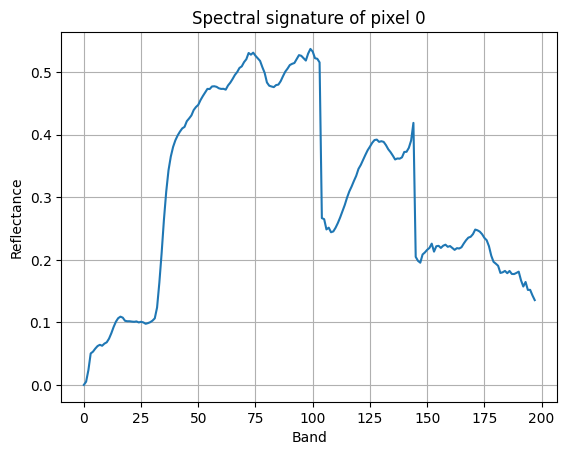

In [7]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

# Reconstruct hyperspectral data (noiseless)
Y = A.T @ M.T  # shape: (pixels, bands)

# Visualize one pixel's spectrum
pixel_id = 0
print("Shape of Y: ",Y.shape)
plt.plot(Y[ pixel_id,:])
plt.title(f"Spectral signature of pixel {pixel_id}")
plt.xlabel("Band")
plt.ylabel("Reflectance")
plt.grid(True)
plt.show()



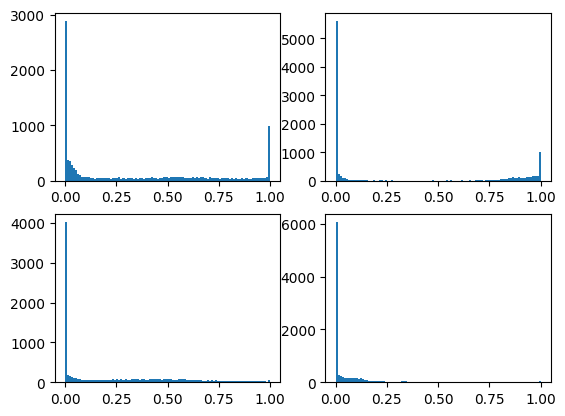

In [8]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(2,2)
axs[0,0].hist(A[0,:],bins=100)
axs[0,1].hist(A[1,:],bins=100)
axs[1,0].hist(A[2,:],bins=100)
axs[1,1].hist(A[3,:],bins=100)
plt.show()

# DirCNNVAE


## Prepare the Data (h x w x n_bands)
### transform Y into image (100x100xn_bands)

In [9]:

Y = A.T @ M.T
Y = Y.astype('float32')
h,w,n_bands=100,100,Y.shape[1]
n_samples,n_bands=Y.shape
print(Y.shape)
# Normalize
Y = Y / Y.max()
Y = np.clip(Y, a_min=0, a_max=None)  # sets negative values to 0
dataset = HSIDataset(0,
                     Y , M, A,
                     n_ems, n_bands, n_samples,
                     None, None,
                     "Cuprite",
                     data_type="float32",
                     random_seed=1234)
dataset.Y=dataset.Y.reshape((h,w,n_bands))
print(dataset.Y.shape)

(10000, 198)
(100, 100, 198)


In [10]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.image import extract_patches_2d

class HyperspectralPatchDataset(Dataset):
    def __init__(self, hyperspectral_image, patch_size=(8, 8)):
        """
        Args:
            hyperspectral_image: numpy array of shape (H, W, C)  [Height, Width, Spectral Bands]
            patch_size: tuple (patch_height, patch_width)
        """
        self.H, self.W, self.C = hyperspectral_image.shape  # (100, 100, C)
        self.patch_size = patch_size

        # Extract patches for each spectral band separately
        patches_list = [extract_patches_2d(hyperspectral_image[:, :, band], patch_size) for band in range(self.C)]

        # Stack along last axis -> (num_patches, patch_size, C)
        self.patches = np.stack(patches_list, axis=-1)

    def __len__(self):
        return self.patches.shape[0]  # Number of patches

    def __getitem__(self, idx):
        patch = self.patches[idx]  # Shape: (patch_size, C)
        patch = torch.tensor(patch, dtype=torch.float32)  # Convert to PyTorch tensor
        patch = patch.permute(2, 0, 1)  # Change shape from (patch_size, C) → (C, patch_size)
        return patch

# Load dataset
dataset = HyperspectralPatchDataset(dataset.Y)  # dataset.Y has shape (100,100, n_bands)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)




##Model


In [11]:
import torch
import torch.nn as nn

import numpy as np

from pprint import pprint


import torch
import torch.nn as nn

from abc import ABC, abstractmethod

class BaseVAE(nn.Module, ABC):
    """
        Skeleton for VAE-based architectures.
    """
    def __init__(self,
                 n_bands: int,
                 n_ems:   int):
        super().__init__()

        self.n_bands = n_bands
        self.n_ems   = n_ems

    @abstractmethod
    def _build_encoder(self) -> nn.Module:
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def _build_decoder(self) -> nn.Module:
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def reparameterize(self, distribution_moment: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    @abstractmethod
    def process_latent(self, input: torch.Tensor):
        raise NotImplementedError

    @abstractmethod
    def forward(self, input: torch.Tensor) -> tuple[torch.Tensor, ...]:
        raise NotImplementedError


class DirCNNVAE(BaseVAE):
    r"""
        Dirichlet CNN VAE based on "Dirichlet Variational Autoencoder"
        by Weonyoung Joo, Wonsung Lee, Sungrae Park & Il-Chul Moon

        Theorem for reparameterization stating that
            if (X_k)_{k=1}^K \sim gamma(\alpha_k, \beta_k) i.i.d
            then if Y = (Y_1, ..., Y_K) such that \forall k
            where

        Sampling in the latent space:
            1) The encoder outputs the moments
            2) we sample
            3) we term-wise normalize by the sum

        Reparameterization trick applied on a random variable
        v \sim multigamma(\alpha, \beta \mathbb{1}_K) based
        thanks to an approximation of the inverse-CDF.
    """
    def __init__(self,
                 n_bands: int,
                 n_ems: int,
                 beta: float,
                 patch_size: int = 12,
                 init_mode='constant',
                 init_value=0.0,
                 encoder_activation_fn: callable = nn.LeakyReLU(),
                 encoder_batch_norm: bool = False):

        super().__init__(n_bands, n_ems)

        # beta = 1 so 1 / beta = 1

        self.patch_size=patch_size
        self.one_over_beta = torch.ones((n_ems,patch_size,patch_size))
        self.encoder_batch_norm    = encoder_batch_norm
        self.encoder_activation_fn = encoder_activation_fn

        self.encoder = self._build_encoder(encoder_activation_fn)
        self.decoder = self._build_decoder()
        self._init_decoder_weights(init_mode=init_mode,init_value=init_value)
    def _build_encoder(self, encoder_activation_fn):
        layers = [
            #nn.Conv2d(self.n_bands, 48, kernel_size=3,padding=1, padding_mode="reflect", bias=False),
            # nn.Conv2d(self.n_bands, 64, kernel_size=3, padding_mode="reflect", bias=False), # patch+1
            # encoder_activation_fn,
            # nn.BatchNorm2d(64),

            nn.Conv2d(self.n_bands, 16, kernel_size=3, padding_mode="reflect", bias=False), # patch+1
            encoder_activation_fn,
            nn.BatchNorm2d(16),

            nn.Conv2d(16, self.n_ems, kernel_size=1, bias=False),
            encoder_activation_fn,
            nn.BatchNorm2d(self.n_ems),
            nn.Softplus()  # Add Softplus correctly
        ]
        return nn.Sequential(*layers)


    def _build_decoder(self):
        decoder = nn.Conv2d(
            self.n_ems,
            self.n_bands,
            kernel_size=1,
            padding=0,
            padding_mode="reflect",
            bias=False,
        )

        return decoder


    def process_latent(self, alphas: torch.Tensor, eps=1e-6) -> torch.Tensor:
        r"""
            Input
            - alpha: params of the dircihlet distrib
            z_latent \sim Dir(\alpha)
        """
        v_latent = self.reparameterize(alphas)
        sum_v = torch.sum(v_latent, dim=1, keepdim=True)
        z_latent = v_latent / (sum_v + 1e-8)

        return z_latent


    def reparameterize(self, alphas: torch.Tensor) -> torch.Tensor:
        r"""
            - u \sim U(0,1)
            - v \sim multigamma(\alpha, \beta \mathbb{1}_K)

            inverse CDF of the multigamma distribution is
            v = CDF^{-1}(u ; \alpha, \beta \mathbb{1}_K) =
                          \beta^{-1}(u * \alpha * \Gamma(\alpha))^{1/\alpha}
        """
        u = torch.rand_like(alphas)

        clamped_alphas = torch.clamp(alphas, max=30) # clamped to avoid NaNs

        int1 = 1 / torch.max(clamped_alphas, 1e-8 * torch.ones_like(clamped_alphas))
        int2 = clamped_alphas.lgamma()
        int3 = int2.exp()
        int4 = int3 * u + 1e-12 # 1e-12 to avoid NaNs
        self.one_over_beta= torch.ones_like(u)

        v_latent = self.one_over_beta * (int4 * clamped_alphas) ** int1

        return v_latent



    def _init_decoder_weights(self,init_mode='constant',init_value=0.0):

      if init_mode=='constant':
        nn.init.constant_(self.decoder.weight,init_value)
        if self.decoder.bias is not None:
          nn.init.constant_(self.decoder.bias,0)
      else:
        nn.init.kaiming_normal_(self.decoder.weight,mode='fan_out',nonlinearity='relu')
        if self.decoder.bias is not None:
          nn.init.constant_(self.decoder.bias,0)

    def get_endmembers(self,
                       layer_idx: int = -1):
        """
            Endmembers are the last layer of the decoders in Palsson AE
        """
        with torch.no_grad():
            ems_tensor =  self.decoder.weight.data.mean((2, 3)).detach()
        return ems_tensor


    def to(self, device):
        """
        Moves the model and its associated buffers to a specified device.

        Parameters:
        - device (torch.device): The device to move the model to. This can be a CPU or a GPU.

        Returns:
        - self (DirCNNVAE): The model instance after moving to the specified device.
        """

        super().to(device)
        #self.one_over_beta = self.one_over_beta.to(device)
        return self



    def forward(self, input: torch.Tensor) -> tuple[torch.Tensor, ...]:
        if input.ndim == 1: input = input.unsqueeze(0)

        alphas   = self.encoder(input)
        z_latent = self.process_latent(alphas)
        output   = self.decoder(z_latent)

        return output, z_latent, alphas


if __name__ == "__main__":

    #from torchinfo import summary

    model = DirCNNVAE(n_bands=10, n_ems=3, beta=1.0 ,patch_size=12,init_mode='constant')
    input = torch.randn(1,10,8,8)
    output,z_latent,alphas=model(input)
    print(f"Output shape: {output.shape}")
    print(f"z_latent shape: {z_latent.shape}")
    print(f"Alphas shape: {alphas.shape}")
    print(z_latent[0,:,0,0])
    print(output[0,:,0,0])
    ems=model.get_endmembers()



Output shape: torch.Size([1, 10, 6, 6])
z_latent shape: torch.Size([1, 3, 6, 6])
Alphas shape: torch.Size([1, 3, 6, 6])
tensor([0.2532, 0.5981, 0.1487], grad_fn=<SelectBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SelectBackward0>)


In [23]:
import torch.nn.functional as F
#from model.dir_cnn_vae import DirCNNVAE

model = DirCNNVAE(n_bands                = n_bands,
                n_ems                 = n_ems,
                beta                  = 1.,
                patch_size=8,
                init_mode='constant',
                  init_value=1e-5,
                encoder_activation_fn = nn.LeakyReLU(),

                encoder_batch_norm    = True
)
init_M= model.get_endmembers().cpu()



In [24]:
import torch
import torch.nn as nn
# parameters of targeted Dirichlet distribution
concentration_sets =np.array([0.3,0.3,0.3,0.1]).reshape(1,-1) #[0.30,0.30,0.30,0.10]
device='cuda' if torch.cuda.is_available() else 'cpu'
rec_loss_fn =SADLoss(mode='cnn',reduction='mean').to(device)  #nn.MSELoss(reduction='mean').to(device)#
reg_loss_fn = GammaKL(torch.from_numpy(concentration_sets),mode='cnn',reduction='mean').to(device) #get_regularization_loss_fn(concentration_sets,loss_name= "gamma_div" ,mode='cnn').to(device)
optimizer_fn = get_optimizer("tf_rms")
optimizer    = optimizer_fn(model.parameters(),
                            0.05,
                            0.99)
n_epochs = 120
reg_factor_initial =5e-8
reg_factor_final=5e-2
trainer = UnsupervisedTrainer()

import math
def exponential_increase_lambda(t, T, lambda_min=reg_factor_initial , lambda_max=reg_factor_final):
    return lambda_min * (lambda_max / lambda_min) ** (t / T)


In [25]:
total_loss, total_rec_loss, total_reg_loss = [], [], []
for epoch in range(n_epochs):
    model.train()
    total_rec_loss_patch, total_reg_loss_patch,total_loss_patch = 0., 0., 0.
    reg_factor=exponential_increase_lambda(epoch, n_epochs-1)
    for batch in dataloader:
        optimizer.zero_grad()
        batch = batch.to(device)
        output, z_latent, alphas = model(batch)
        batch_cropped = batch[:, :, 1:7, 1:7]  # Crop center region from 12x12 → 8x8
        rec_loss = rec_loss_fn(output, batch_cropped)
        reg_loss = reg_loss_fn(alphas)
        loss = rec_loss + reg_factor * reg_loss


        loss.backward()
        optimizer.step()

        # Enforce non-negativity constraint on decoder weights
        with torch.no_grad():
            model.decoder.weight.data.clamp_(min=0.0)


        total_rec_loss_patch += rec_loss.item()
        total_reg_loss_patch += reg_loss.item()
        total_loss_patch += loss.item()

    total_loss.append(total_loss_patch / len(dataloader))
    total_rec_loss.append(total_rec_loss_patch / len(dataloader))
    total_reg_loss.append(total_reg_loss_patch / len(dataloader))

    print(f"Epoch {epoch}: Rec Loss = {total_rec_loss_patch / len(dataloader):.4f}, "
          f"Reg Loss = {total_reg_loss_patch / len(dataloader):.4f}")

Epoch 0: Rec Loss = 0.5949, Reg Loss = 0.6834
Epoch 1: Rec Loss = 0.5627, Reg Loss = 0.6905
Epoch 2: Rec Loss = 0.5404, Reg Loss = 0.7014
Epoch 3: Rec Loss = 0.5216, Reg Loss = 0.7096
Epoch 4: Rec Loss = 0.5054, Reg Loss = 0.7189
Epoch 5: Rec Loss = 0.4927, Reg Loss = 0.7323
Epoch 6: Rec Loss = 0.4826, Reg Loss = 0.7535
Epoch 7: Rec Loss = 0.4736, Reg Loss = 0.7825
Epoch 8: Rec Loss = 0.4654, Reg Loss = 0.8153
Epoch 9: Rec Loss = 0.4589, Reg Loss = 0.8451
Epoch 10: Rec Loss = 0.4532, Reg Loss = 0.8710
Epoch 11: Rec Loss = 0.4482, Reg Loss = 0.8947
Epoch 12: Rec Loss = 0.4435, Reg Loss = 0.9206
Epoch 13: Rec Loss = 0.4391, Reg Loss = 0.9505
Epoch 14: Rec Loss = 0.4346, Reg Loss = 0.9842
Epoch 15: Rec Loss = 0.4302, Reg Loss = 1.0218
Epoch 16: Rec Loss = 0.4261, Reg Loss = 1.0656
Epoch 17: Rec Loss = 0.4221, Reg Loss = 1.1199
Epoch 18: Rec Loss = 0.4182, Reg Loss = 1.1787
Epoch 19: Rec Loss = 0.4143, Reg Loss = 1.2390
Epoch 20: Rec Loss = 0.4107, Reg Loss = 1.3034
Epoch 21: Rec Loss = 0.

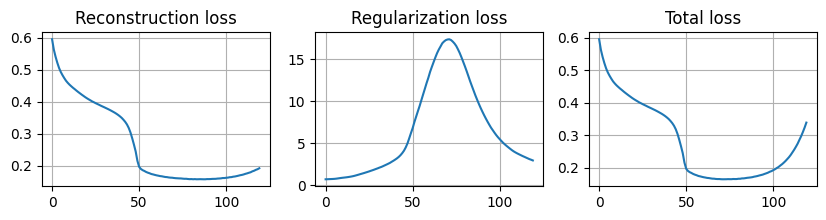

In [26]:
results={}
results['reconstruction_loss']=total_rec_loss
results['regularization_loss']=total_reg_loss
results['total_loss']=total_loss
fig, axs = plt.subplots(1, 3, figsize=(10,2))

axs[0].plot(results["reconstruction_loss"])
axs[0].set_title("Reconstruction loss")
axs[0].grid()

axs[1].plot(results["regularization_loss"])
axs[1].set_title("Regularization loss")
axs[1].grid()

axs[2].plot(results["total_loss"])
axs[2].set_title("Total loss")

axs[2].grid()

plt.show()

In [27]:
# compute results
pred_M = model.get_endmembers().cpu()
print(pred_M.shape)

torch.Size([198, 4])


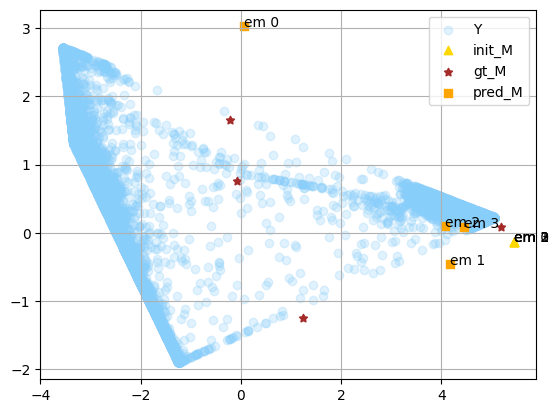

In [28]:
M_GT=M
#sad metric
avg_sad = get_average_accuracy_on_M(pred_M,
                                    torch.from_numpy(M_GT),
                                    criterion=get_reconstruction_loss_fn("sad"))
sad_by_ems = get_accuracy_on_M(pred_M,
                                torch.from_numpy(M_GT),
                                criterion=get_reconstruction_loss_fn("sad"))
# #mse metric
avg_mse = get_average_accuracy_on_M(pred_M,
                                    torch.from_numpy(M_GT),
                                    criterion=get_reconstruction_loss_fn("mse"))
mse_by_ems = get_accuracy_on_M(pred_M,
                                torch.from_numpy(M_GT),
                                criterion=get_reconstruction_loss_fn("mse"))

# # create log folder to store results
path_to_log_dir = create_log_folder("./logs")

log_metrics(avg_sad, sad_by_ems, avg_mse, mse_by_ems, path_to_log_dir)
log_figure(Y,
           pred_M,
           M_GT,
           init_M,
           path_to_log_dir,
           debug=True,
           show=True,
           verbose=False,
           save=True,
           )


In [29]:
import numpy as np
print(pred_M.shape)
print(M_GT.shape)
endmembers=np.array(pred_M).T
endmembersGT=np.array(M_GT).T
print(endmembers.shape)
print(endmembersGT.shape)

torch.Size([198, 4])
(198, 4)
(4, 198)
(4, 198)


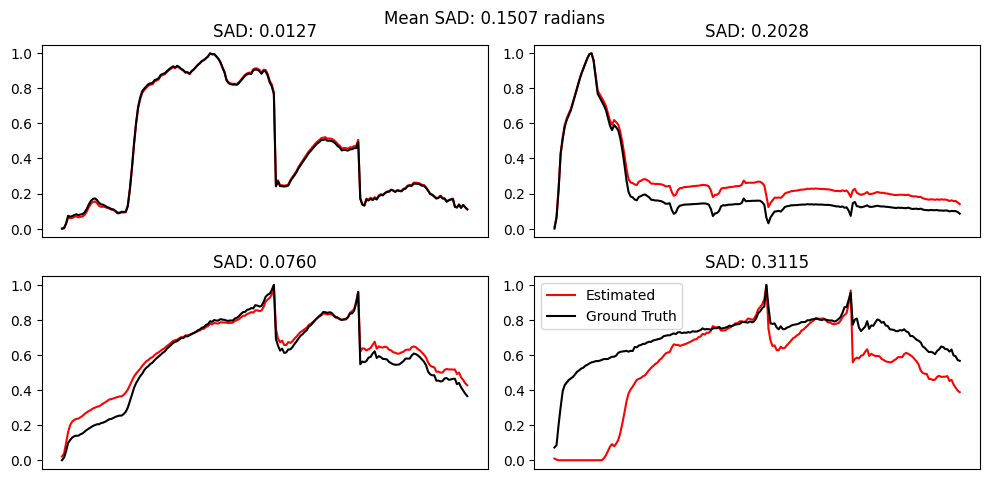

In [30]:

def numpy_SAD(y_true, y_pred):
    """NumPy version of SAD for plotting"""
    cos = y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred))
    if cos > 1.0:
        cos = 1.0
    return np.arccos(cos)

def order_endmembers(endmembers_est, endmembers_gt, num_endmembers=4):
    # Normalize without modifying originals
    est = endmembers_est / (endmembers_est.max(axis=1, keepdims=True) + 1e-8)
    gt = endmembers_gt / (endmembers_gt.max(axis=1, keepdims=True) + 1e-8)

    # SAD matrix
    sad_mat = np.zeros((num_endmembers, num_endmembers))
    for i in range(num_endmembers):
        for j in range(num_endmembers):
            sad_mat[i, j] = numpy_SAD(est[i], gt[j])

    # Greedy matching
    mapping = {}
    used_gt = set()
    for _ in range(num_endmembers):
        i, j = np.unravel_index(np.argmin(sad_mat), sad_mat.shape)
        while i in mapping or j in used_gt:
            sad_mat[i, j] = np.inf
            i, j = np.unravel_index(np.argmin(sad_mat), sad_mat.shape)
        mapping[i] = j
        used_gt.add(j)
        sad_mat[i, j] = np.inf

    # Compute mSAD
    mSAD = np.mean([numpy_SAD(est[i], gt[j]) for i, j in mapping.items()])
    return mapping, mSAD
def plotEndmembersAndGT(endmembers_est, endmembers_gt, num_endmembers=4):
    if isinstance(endmembers_est, torch.Tensor):
        endmembers_est = endmembers_est.detach().cpu().numpy()
    if isinstance(endmembers_gt, torch.Tensor):
        endmembers_gt = endmembers_gt.detach().cpu().numpy()

    mapping, mSAD = order_endmembers(endmembers_est, endmembers_gt, num_endmembers)

    # Reverse mapping: GT index → matched estimated index
    reverse_mapping = {v: k for k, v in mapping.items()}

    rows = 2
    cols = (num_endmembers + 1) // 2
    fig = plt.figure(figsize=(10, 5))
    plt.clf()
    title = f"Mean SAD: {mSAD:.4f} radians"
    st = plt.suptitle(title)

    for i in range(num_endmembers):
        gt = endmembers_gt[i, :] / (endmembers_gt[i, :].max() + 1e-8)
        est = endmembers_est[reverse_mapping[i], :] / (endmembers_est[reverse_mapping[i], :].max() + 1e-8)

        ax = plt.subplot(rows, cols, i + 1)
        plt.plot(est, 'r', label='Estimated')
        plt.plot(gt, 'k', label='Ground Truth')
        sad_value = numpy_SAD(est, gt)
        ax.set_title(f"SAD: {sad_value:.4f}")
        ax.get_xaxis().set_visible(False)

    plt.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.88)
    plt.legend()
    plt.draw()
    plt.pause(0.001)


plotEndmembersAndGT(endmembers,endmembersGT,4)